Berikut adalah multiklasifikasi untuk kasus **SMS**. <br> 
Disini akan dikelompokan kategori sms yang mengandung konten sms normal (sms), sms penipuan(penipuan), dan sms promo(promo).

In [134]:
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, Dropout, Activation, Embedding, Bidirectional, Masking


In [135]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [136]:
df_train = pd.read_csv('/content/drive/My Drive/spam.csv')

In [137]:
df_train

,Teks,label
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,promo
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,promo
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",promo
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",promo
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,promo
...,...,...
1138,"Yooo sama2, oke nanti aku umumin di grup kelas",sms
1139,😁 sebelumnya ga ad nulis kerudung. Kirain warn...,sms
1140,Mba mau kirim 300 ya,sms
1141,nama1 beaok bwrangkat pagi...mau cas atay tra...,sms


**Data preprocessing and Cleaning**

In [138]:
category = pd.get_dummies(df_train.label)

In [139]:
print(category)

      penipuan  promo  sms
0            0      1    0
1            0      1    0
2            0      1    0
3            0      1    0
4            0      1    0
...        ...    ...  ...
1138         0      0    1
1139         0      0    1
1140         0      0    1
1141         0      0    1
1142         0      0    1

[1143 rows x 3 columns]


**Terdapat 1000 Sample**

In [140]:
df_baru = pd.concat([df_train, category], axis=1)
df_baru = df_baru.drop(columns='label')
df_baru

,Teks,penipuan,promo,sms
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,0,1,0
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,0,1,0
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",0,1,0
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",0,1,0
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,0,1,0
...,...,...,...,...
1138,"Yooo sama2, oke nanti aku umumin di grup kelas",0,0,1
1139,😁 sebelumnya ga ad nulis kerudung. Kirain warn...,0,0,1
1140,Mba mau kirim 300 ya,0,0,1
1141,nama1 beaok bwrangkat pagi...mau cas atay tra...,0,0,1


In [141]:
teks = df_baru['Teks'].values
label = df_baru[['penipuan', 'promo', 'sms']].values

**Training and Validation Spliting** <br>
dengan 20% data test. sudah menggunakan fungsi tokenizer untuk menggabungkan data teks.

In [142]:
from sklearn.model_selection import train_test_split
teks_latih, teks_test, label_latih, label_test = train_test_split(teks, label, test_size=0.2)

In [143]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
 
tokenizer = Tokenizer(num_words=5000, oov_token='x')
tokenizer.fit_on_texts(teks_latih) 
tokenizer.fit_on_texts(teks_test)
 
sekuens_latih = tokenizer.texts_to_sequences(teks_latih)
sekuens_test = tokenizer.texts_to_sequences(teks_test)
 
padded_latih = pad_sequences(sekuens_latih) 
padded_test = pad_sequences(sekuens_test)

Terdapat 3 kelas kategorikal, dilihat dari shape.

In [144]:
print(label.shape)

(1143, 3)


**Pembuatan Model Layer** <br>
menggunakan embedding dan LSTM. relu dibuat agar fully connected antar layer
sementara dropout untuk mengurangi overfitting.

In [219]:
model=Sequential()

model.add(Embedding(vocab_size,16))
model.add(Masking(mask_value=0.0))
# model.add(Dropout(0.6))
model.add((LSTM(16)))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3,activation='softmax'))
model.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_32 (Embedding)     (None, None, 16)          80000     
_________________________________________________________________
masking_12 (Masking)         (None, None, 16)          0         
_________________________________________________________________
lstm_32 (LSTM)               (None, 16)                2112      
_________________________________________________________________
dense_43 (Dense)             (None, 8)                 136       
_________________________________________________________________
dropout_32 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_44 (Dense)             (None, 3)                 27        
Total params: 82,275
Trainable params: 82,275
Non-trainable params: 0
_________________________________________________

In [220]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
modelcheckpoint = ModelCheckpoint(
    filepath='./nlpsms.hdf5',
    monitor='loss',
    save_best_only=True,
    period=1
)
earlystopping = EarlyStopping(
    monitor='loss', 
    min_delta=0.001, 
    patience=10
)

**Compile Model**

In [221]:

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)

**Model Fitting dan Proses Training**

In [222]:
num_epochs = 100
history = model.fit(padded_latih, label_latih, epochs=num_epochs, validation_data=(padded_test, label_test), verbose=2,callbacks=[modelcheckpoint, earlystopping])

Epoch 1/100
29/29 - 2s - loss: 1.0901 - accuracy: 0.5481 - val_loss: 1.0782 - val_accuracy: 0.6332
Epoch 2/100
29/29 - 1s - loss: 1.0421 - accuracy: 0.6827 - val_loss: 0.9738 - val_accuracy: 0.7205
Epoch 3/100
29/29 - 1s - loss: 0.8734 - accuracy: 0.7309 - val_loss: 0.7963 - val_accuracy: 0.7205
Epoch 4/100
29/29 - 1s - loss: 0.7238 - accuracy: 0.7451 - val_loss: 0.6300 - val_accuracy: 0.7598
Epoch 5/100
29/29 - 1s - loss: 0.5751 - accuracy: 0.7910 - val_loss: 0.5147 - val_accuracy: 0.8035
Epoch 6/100
29/29 - 1s - loss: 0.4773 - accuracy: 0.8359 - val_loss: 0.4300 - val_accuracy: 0.8341
Epoch 7/100
29/29 - 1s - loss: 0.3876 - accuracy: 0.8556 - val_loss: 0.3574 - val_accuracy: 0.8821
Epoch 8/100
29/29 - 1s - loss: 0.3469 - accuracy: 0.8665 - val_loss: 0.3271 - val_accuracy: 0.8865
Epoch 9/100
29/29 - 1s - loss: 0.2998 - accuracy: 0.8862 - val_loss: 0.3052 - val_accuracy: 0.8777
Epoch 10/100
29/29 - 1s - loss: 0.2987 - accuracy: 0.8796 - val_loss: 0.3267 - val_accuracy: 0.8646
Epoch 11/

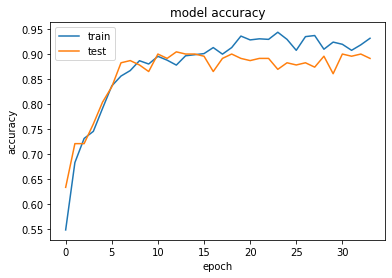

In [223]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

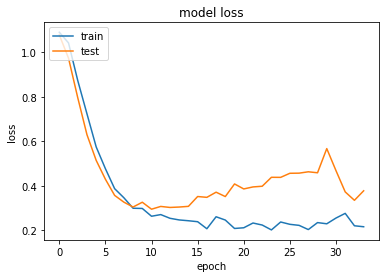

In [224]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Testing** <br>
testing dilakukan dengan tidak menggunakan data selain data training
mesin sudah mampu memprediksi label yang dimaksud.

In [225]:
txt = ["dapatkan hadiah menarik dari kami"]

seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_length)
pred = model.predict(padded)
labels = ['penipuan', 'promo', 'sms']

print(pred)
print(np.argmax(pred))
print(labels[np.argmax(pred)])

[[0.45960763 0.28417915 0.25621316]]
0
penipuan


In [226]:
txt = ["ayo download penawaran kami"]

seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_length)
pred = model.predict(padded)
labels = ['penipuan', 'promo', 'sms']

print(pred)
print(np.argmax(pred))
print(labels[np.argmax(pred)])

[[0.02995974 0.04310292 0.92693734]]
2
sms


In [227]:
txt = ["Waalaikumsalamin apa yg dpt saya bantu min?"]

seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_length)
pred = model.predict(padded)
labels = ['penipuan', 'promo', 'sms']

print(pred)
print(np.argmax(pred))
print(labels[np.argmax(pred)])

[[0.00272824 0.00600423 0.9912675 ]]
2
sms


In [236]:
txt = ["pulsamu tinggal dikit? Beli pakai pulsa aja Bro, dapatkan sekarang "]
seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_length)
pred = model.predict(padded)
labels = ['penipuan', 'promo', 'sms']

print(pred)
print(np.argmax(pred))
print(labels[np.argmax(pred)])

[[0.09668239 0.7483626  0.15495509]]
1
promo


In [237]:
txt = ["lagi apa sayang?"]
seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_length)
pred = model.predict(padded)
labels = ['penipuan', 'promo', 'sms']

print(pred)
print(np.argmax(pred))
print(labels[np.argmax(pred)])

[[0.00303298 0.00660947 0.9903576 ]]
2
sms


-----------------------------------------------------------
**Profil Peserta**

Nama Lengkap : Ilham Winar Nugroho <br>
Nomer Telepon : 087838014299 <br>
Domisili : Tangerang <br>
Tentang Saya : Tertarik Belajar Machine Learning <br>
Pekerjaan : Pegawai BUMN <br>